# Logistic Regression

## References

https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

## Import Python Libraries

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Global Variables

In [97]:
# random state 
random_state = 4781

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

# max number of features 
k = 10

## Import Dataset

In [98]:
# Source: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: age
# X02: sex
# X03: chest pain type (4 values)
# X04: resting blood pressure
# X05: serum cholestoral in mg/dl
# X06: fasting blood sugar > 120 mg/dl
# X07: resting electrocardiographic results (values 0,1,2)
# X08: maximum heart rate achieved
# X09: exercise induced angina
# X10: oldpeak = ST depression induced by exercise relative to rest
# X11: the slope of the peak exercise ST segment
# X12: number of major vessels (0-3) colored by flourosopy
# X13: thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
#   Y: target: presence of heart disease, 0 = no disease and 1 = disease.

In [99]:
# load heart.csv dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/heart.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [100]:
df0.columns.copy

<bound method Index.copy of Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')>

In [101]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'target'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [102]:
# standardize column names
df1 = df0.copy()
new_all_cols = all_cols.copy()

temp = (np.arange(0, len(X_cols)) + 1)
temp = temp.astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(2) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

temp = {all_cols[i]: new_all_cols[i] for i in range(len(all_cols))}

df1 = df1.rename(columns = temp)
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [103]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     1025 non-null   int64  
 1   X02     1025 non-null   int64  
 2   X03     1025 non-null   int64  
 3   X04     1025 non-null   int64  
 4   X05     1025 non-null   int64  
 5   X06     1025 non-null   int64  
 6   X07     1025 non-null   int64  
 7   X08     1025 non-null   int64  
 8   X09     1025 non-null   int64  
 9   X10     1025 non-null   float64
 10  X11     1025 non-null   int64  
 11  X12     1025 non-null   int64  
 12  X13     1025 non-null   int64  
 13  y       1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [104]:
# describe data
df1.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [105]:
# check missing values
df1.count()

X01    1025
X02    1025
X03    1025
X04    1025
X05    1025
X06    1025
X07    1025
X08    1025
X09    1025
X10    1025
X11    1025
X12    1025
X13    1025
y      1025
dtype: int64

## Data Cleaning

Not Needed

## Transform Dataset

In [106]:
# user defined function to normalize data
def jra_znormalize(x):
  mu = np.mean(x)
  sigma = np.std(x)
  x = (x - mu) / sigma
  return(x)  

In [107]:
# response column
y_col = new_y_col
y_col

'y'

In [108]:
# predictor columns
X_cols = new_X_cols
X_cols

['X01',
 'X02',
 'X03',
 'X04',
 'X05',
 'X06',
 'X07',
 'X08',
 'X09',
 'X10',
 'X11',
 'X12',
 'X13']

In [109]:
# rename response labels
labels = {
  0: 'no disease',
  1: 'disease'
}
cond1 = df1[y_col] == 0
cond2 = df1[y_col] == 1
df1.loc[cond1, y_col] = labels[0]
df1.loc[cond2, y_col] = labels[1]

df1.head()

C:\Users\80148956\AppData\Local\Temp\ipykernel_34200\719524199.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'no disease' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.loc[cond1, y_col] = labels[0]


,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,no disease
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,no disease
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,no disease
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,no disease
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,no disease


In [110]:
# normalize all X_cols using z-score standardizaion (df2)
df2 = df1.copy()
df2[X_cols] = df1[X_cols].apply(jra_znormalize)
df2.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,y
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852,no disease
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852,no disease
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852,no disease
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852,no disease
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122,no disease


In [111]:
# melt df2 into a dataframe where cols become stacked as rows
df3 = df2.melt(
  id_vars = y_col,
  value_vars = X_cols,
  var_name = 'X',
  value_name = "X_value"
)
df3.head()

,y,X,X_value
0,no disease,X01,-0.268437
1,no disease,X01,-0.158157
2,no disease,X01,1.716595
3,no disease,X01,0.724079
4,no disease,X01,0.834359


## Visualize Dataset

In [112]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols)
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)

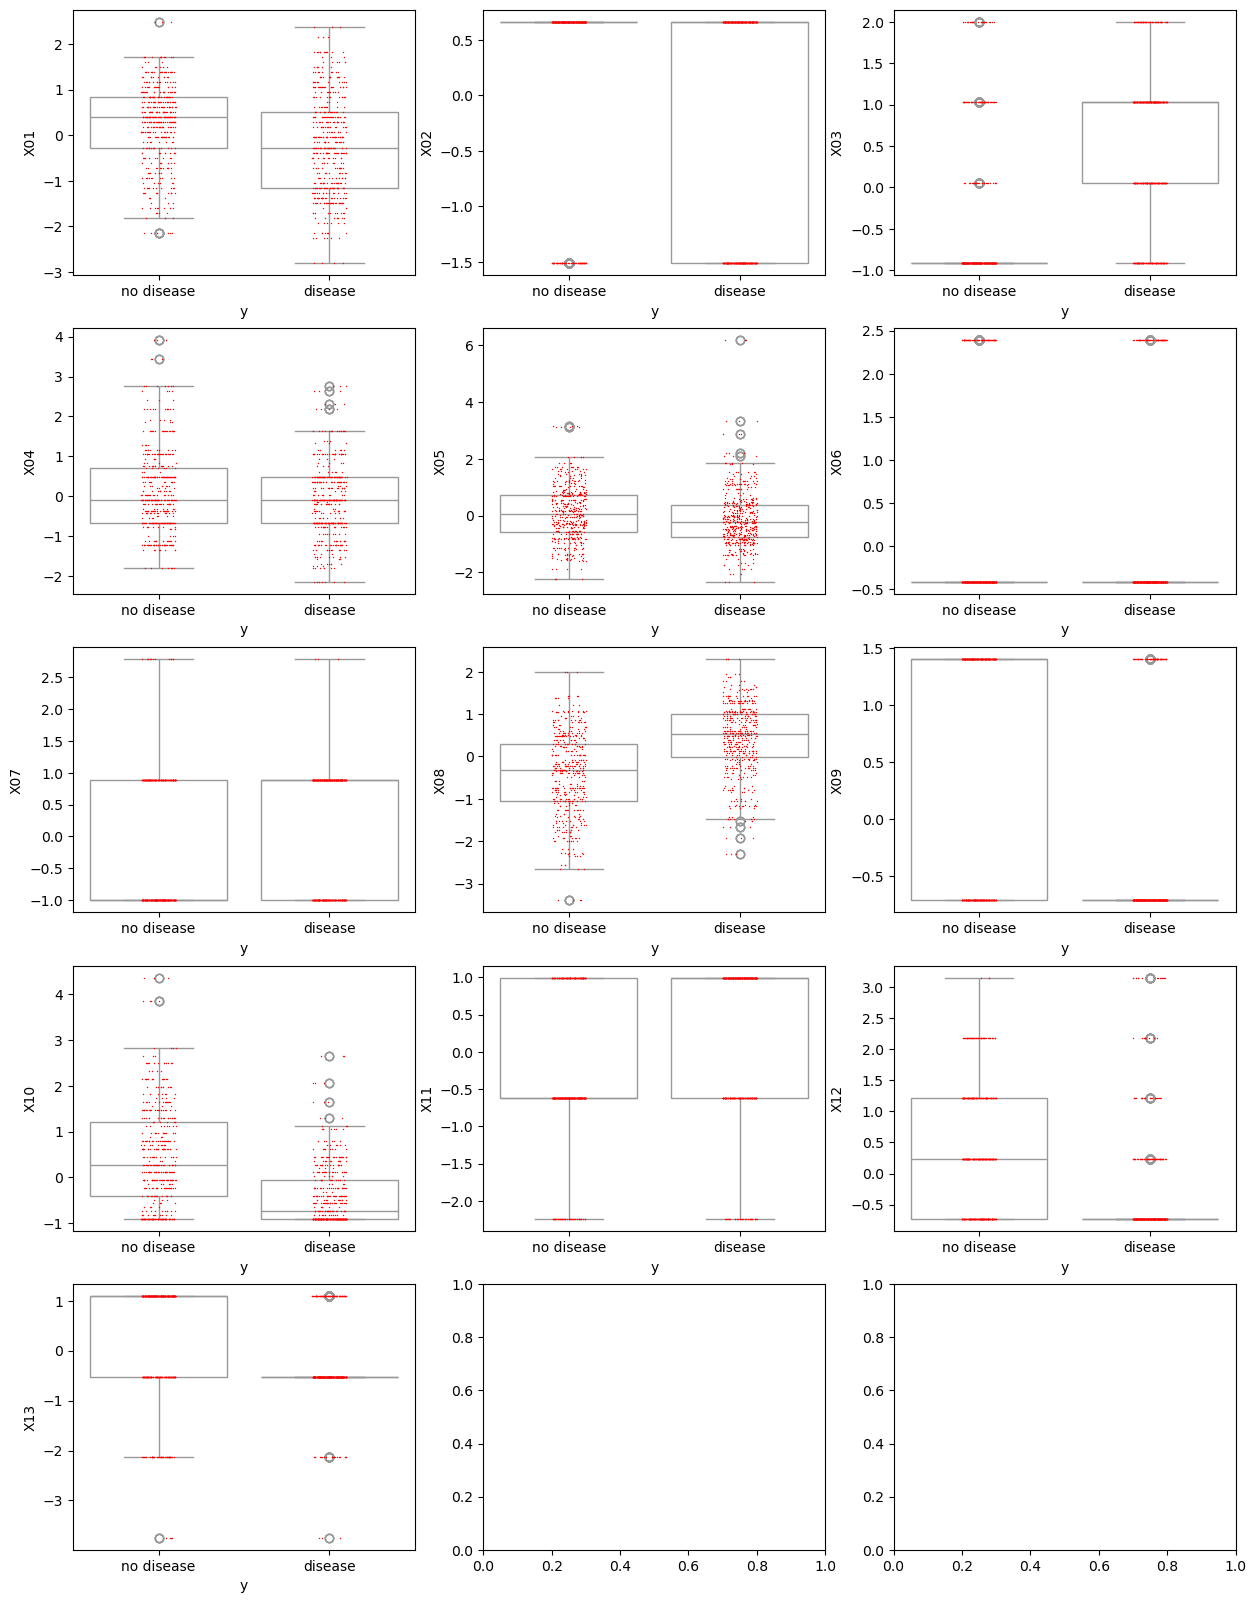

In [113]:
# subplot of y vs each X (boxplot + stripplot)
f1, axes = plt.subplots(5, fig_cols, figsize = (15, 20))
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  sns.boxplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = [c1, c1])
  sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

In [114]:
# subplot of y vs each X (stripplot + violinplot)
f1, axes = plt.subplots(5, fig_cols, figsize = (15, 20))
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = [c1, c1])
  sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

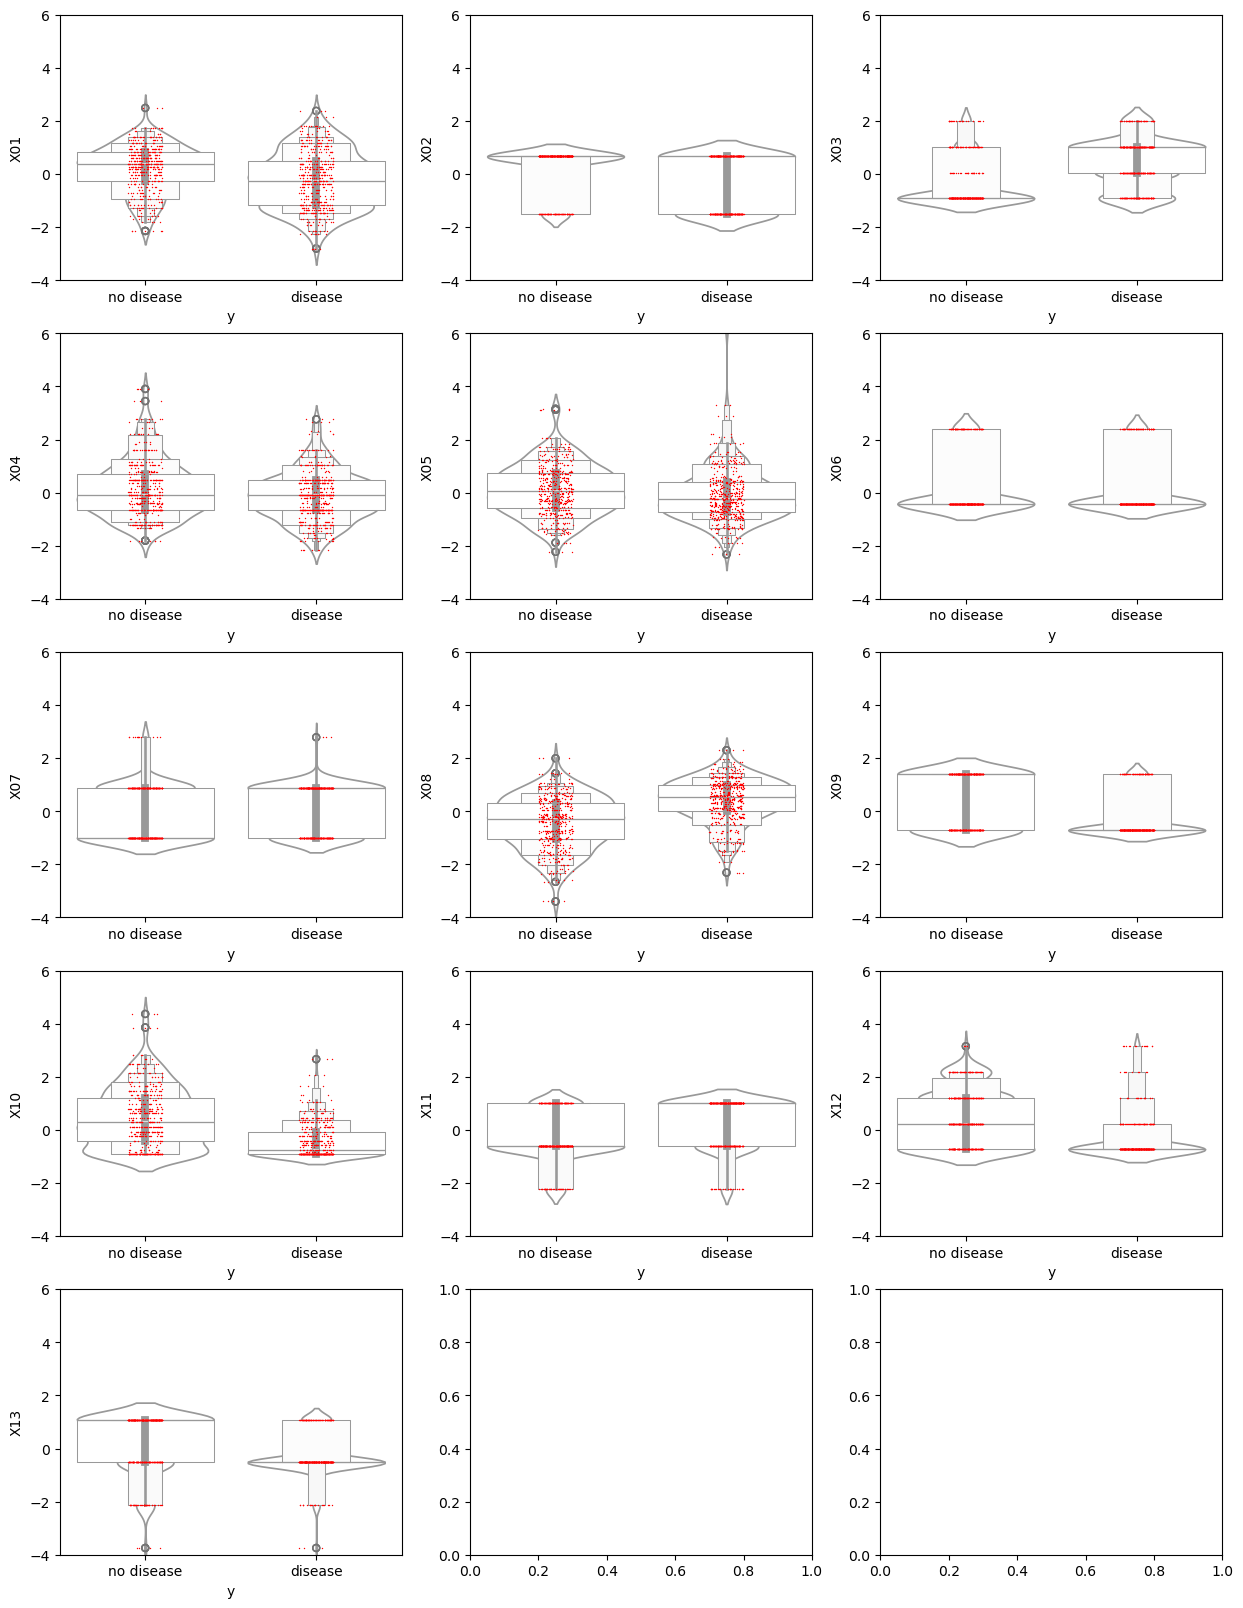

In [ ]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(5, fig_cols, figsize = (15, 20))
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = [c1, c1])
  sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = [c1, c1])
  axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

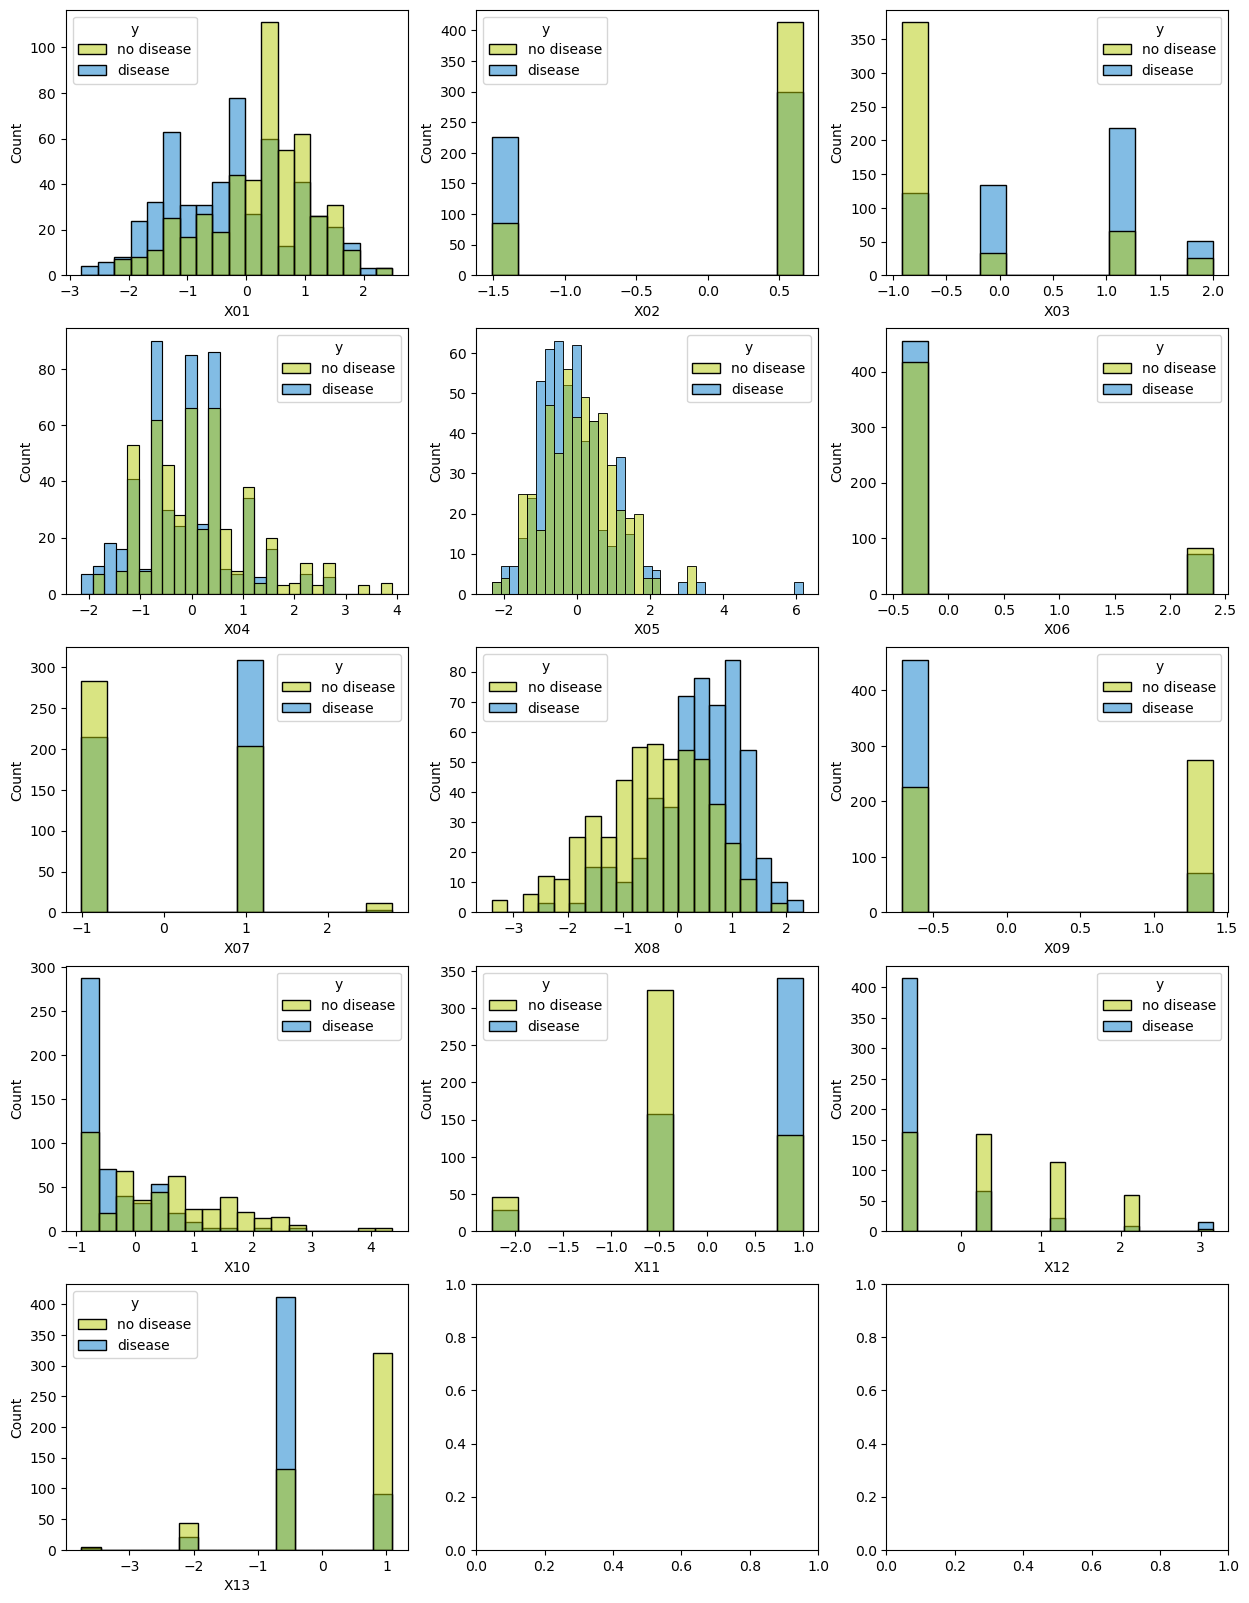

In [ ]:
# subplot of each X (histplot)
f1, axes = plt.subplots(5, fig_cols, figsize = (15, 20))
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  sns.histplot(ax = axes[row, col], data = df2, x = x, hue = y_col, palette = [c3, c4])
  itr = itr + 1

## Feature Selection

### Split Data into X and y parts

In [ ]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

### Remove Features Having % Similar Values or More

In [ ]:
# porportion similar (p)
p = 0.75
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

0.75 0.25


In [ ]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [ ]:
# fit model
temp = myfit.fit_transform(X, y)

In [ ]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13'], dtype=object)

### Keep Top k Features Based on Univariate Testing of X Against y

In [ ]:
# initalize univariate test model
myfit = SelectKBest(
  score_func = f_classif, 
  k = k
)

In [ ]:
# fit model
temp = myfit.fit_transform(X, y)

In [ ]:
# get k best columns
X_cols_k_best = myfit.get_feature_names_out()
X_cols_k_best

array(['X01', 'X02', 'X03', 'X04', 'X08', 'X09', 'X10', 'X11', 'X12',
       'X13'], dtype=object)

### Keep Top k Features Based on Recursive Feature Elimination

In [ ]:
# intializ estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 100,
  criterion = "gini",
  random_state = random_state
)

In [ ]:
# initialize recursive feature elimination model
myfit = RFE(
  estimator = estimator_model,
  n_features_to_select = k
)

In [ ]:
# fit model
temp = myfit.fit_transform(X, y)

In [ ]:
# get k best columns
X_cols_rfe = myfit.get_feature_names_out()
X_cols_rfe

array(['X01', 'X03', 'X04', 'X05', 'X08', 'X09', 'X10', 'X11', 'X12',
       'X13'], dtype=object)

### Select Features Using Model Selection Methods

#### Lasso - L1 Feature Selection

In [ ]:
# intializ estimator model
estimator_model = LogisticRegression(
  solver = 'saga',
  penalty = 'l1', # lasso
  fit_intercept = True,
  max_iter = 10000,
  random_state = random_state
)

In [ ]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  max_features = k
)

In [ ]:
# fit model
temp = myfit.fit_transform(X, y)

In [ ]:
# get columns kept from lasso feature selection
X_cols_lasso = myfit.get_feature_names_out()
X_cols_lasso

array(['X02', 'X03', 'X04', 'X05', 'X08', 'X09', 'X10', 'X11', 'X12',
       'X13'], dtype=object)

#### Model Specific Feature Selection (e.g. Ensemble - Random Forest)

In [ ]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [ ]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [ ]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.08578059, 0.03900334, 0.13876271, 0.06773803, 0.08095509,
       0.00852383, 0.02064132, 0.10304795, 0.06101094, 0.11370479,
       0.03944802, 0.12811692, 0.11326647])

In [ ]:
# mean feature importance
mean_feature_importance = np.mean(feature_importance)
mean_feature_importance

0.07692307692307693

In [ ]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = mean_feature_importance
)

In [ ]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [ ]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X01', 'X03', 'X05', 'X08', 'X10', 'X12', 'X13'], dtype=object)

## Train and Test ML Model

In [ ]:
# X_cols to include after feature selection
# X_include = X_cols
# X_include = X_cols_var_threshold
# X_include = X_cols_k_best
# X_include = X_cols_rfe
# X_include = X_cols_lasso
X_include = X_cols_rf

In [ ]:
# seperate data into X and y
X = df2[X_include]
y = np.ravel(df2[y_col])

In [ ]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y,
  random_state = random_state, train_size = 0.7
)

In [ ]:
# initialize logistic regression model
myfit = LogisticRegression(
  fit_intercept = True,
  max_iter = 10000,
  random_state = random_state
)

In [ ]:
# fit model
temp = myfit.fit(X_train, y_train)

In [ ]:
# get predictions on test data
y_hat = myfit.predict(X_test)

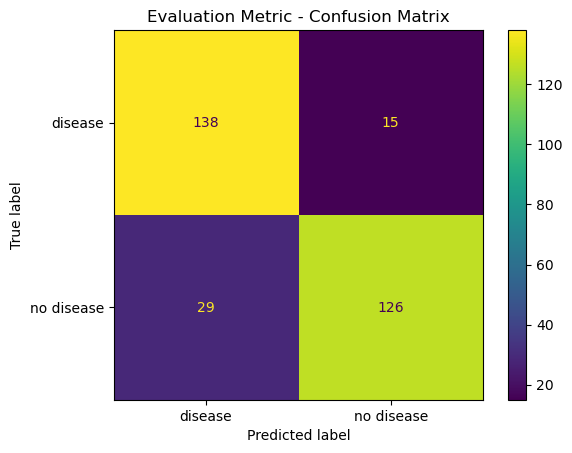

In [ ]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [ ]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False) 
print(metric_report)

              precision    recall  f1-score   support

     disease       0.83      0.90      0.86       153
  no disease       0.89      0.81      0.85       155

    accuracy                           0.86       308
   macro avg       0.86      0.86      0.86       308
weighted avg       0.86      0.86      0.86       308

